In [1]:
%reload_ext autoreload
%autoreload 2

import os
import shutil
import numpy as np

import matplotlib.pyplot as plt
from  matplotlib.ticker import FuncFormatter
plt.set_cmap('gray')
plt.rcParams['figure.figsize'] = (8, 6)

from glob import glob
from tqdm.notebook import tqdm
import pydicom
import pandas as pd
import seaborn as sns
from sklearn.metrics import cohen_kappa_score, confusion_matrix
import pingouin as pg
from scipy.stats import wilcoxon, pearsonr
import statsmodels.formula.api as smf
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def process_reader_response(fpath_csv):
    res_dict = pd.read_csv(fpath_csv).to_dict(orient='records')
    proc_cols = ['enhancement', 'delineation', 'morphology', 'conspicuity', 'iq', 'dx']
    num_proc = lambda item: int(item.split(' = ')[0])
    nan_proc = lambda item: '' if not isinstance(item, str) else item
    
    proc_map = {
        'case': lambda item: item,
        'enhancement': num_proc,
        'delineation': num_proc,
        'morphology': num_proc,
        'conspicuity': num_proc,
        'iq': num_proc,
        'dx': num_proc,
        'comments': nan_proc
    }
    
    proc_dict = []
    for res_row in res_dict:
        proc_row = {}
        for col, val in res_row.items():
            proc_fn = proc_map[col]
            val = proc_fn(val)
            proc_row[col] = val
        proc_dict.append(proc_row)
    return proc_dict

def get_repeat_cases(case_map, case_type='soc'):
    if case_type == 'soc':
        cases_filt = [c for c in case_map if '_boost' not in c['Original ID']]
    else:
        cases_filt = [c for c in case_map if '_boost' in c['Original ID']]
    
    repeat_cases = []
    visited = []
    
    for row in cases_filt:
        case_id = row['Case ID']
        orig_id = row['Original ID']
        
        rep = [
            c for c in cases_filt 
            if (c['Original ID'] == orig_id) and (c['Case ID'] != case_id) and 
            (c['Case ID'] not in visited) and (c['Case ID'] not in repeat_cases)
        ]
        
        if len(rep) > 0:
            repeat_cases.append(rep[0]['Case ID'])
            visited.append(rep[0]['Case ID'])
        
        visited.append(case_id)
    
    return sorted(repeat_cases)

def compile_reader_scores(fpath_csv, reader_id, case_map, soc_reps, bst_reps, dx_gt):
    res_dict = process_reader_response(fpath_csv)
    score_rows = []
    
    for row in res_dict:
        map_info = [r for r in case_map if r['Case ID'] == row['case']][0]
        dx_gt_row = [r for r in dx_gt if map_info['Original ID'].replace('_boost', '') == r['original']][0]
        
        score_rows.append({
            'case': row['case'],
            'type': 'boost' if '_boost' in map_info['Original ID'] else 'soc',
            'original': map_info['Original ID'].replace('_boost', ''),
            'reader': reader_id,
            'repeat': 'yes' if (row['case'] in soc_reps or row['case'] in bst_reps) else 'no',
            'enhancement': row['enhancement'],
            'delineation': row['delineation'],
            'morphology': row['morphology'],
            'conspicuity': row['conspicuity'],
            'conspicuity_affects_dx': 'yes' if row['conspicuity'] in [1, 5] else 'no',
            'iq': row['iq'],
            'dx': row['dx'],
            'dx_gt': dx_gt_row['dx_gt'],
            'comments': row['comments']
        })
    
    return score_rows

def plot_confusion_matrix(y_true, y_pred, dx_map, ax=None, title=None, tick_kws={}):
    cfm = confusion_matrix(y_true, y_pred)
    if ax is None:
        ax = plt.subplot()
    labels = [v for k, v in dx_map.items() if k in y_true or k in y_pred]
    
    sns.heatmap(cfm, annot=True, ax=ax, cbar=False)
    _ = ax.xaxis.set_ticklabels(labels, rotation=45, **tick_kws)
    _ = ax.yaxis.set_ticklabels(labels, rotation=45, **tick_kws)
    _ = ax.set_title(title)    
    
def get_pct_and_kappa(y_true, y_pred):
    pct = len([v for i, v in enumerate(y_true) if v == y_pred[i]]) / len(y_true)
    kap = cohen_kappa_score(y_true, y_pred)
    return pct, kap

def plot_hist_with_pval(df_scores, col, alt='greater'):
    df_soc = df_scores.query('type == "soc" and repeat == "no"').sort_values(['original', 'reader'])
    df_bst = df_scores.query('type == "boost" and repeat == "no"').sort_values(['original', 'reader'])

    enh_soc = np.array(df_soc[col])
    enh_bst = np.array(df_bst[col])

    _, pval = wilcoxon(enh_bst, enh_soc, alternative='greater')

    hplot = sns.histplot(enh_bst-enh_soc)
    hplot.set_title('Difference in {} (BOOST - SOC) | p-val={}'.format(col, pval))

def get_agreement_rows(df_scores, reader1, reader2, comb_id):
    pid_map = {orig_id: idx for idx, orig_id in enumerate(sorted(list(set(df_scores['original']))))}

    dict_ixg_a_soc = df_scores.query(
        'reader == @reader1 and repeat == "no" and type == "soc"'
    ).sort_values('original').to_dict(orient='records')

    dict_ixg_b_soc = df_scores.query(
        'reader == @reader2 and repeat == "no" and type == "soc"'
    ).sort_values('original').to_dict(orient='records')

    dict_ixg_a_bst = df_scores.query(
        'reader == @reader1 and repeat == "no" and type == "boost"'
    ).sort_values('original').to_dict(orient='records')

    dict_ixg_b_bst = df_scores.query(
        'reader == @reader2 and repeat == "no" and type == "boost"'
    ).sort_values('original').to_dict(orient='records')

    ixg_rows = []

    for idx, row in enumerate(dict_ixg_a_soc):
        b_row = dict_ixg_b_soc[idx]

        ixg_rows.append({
            'case': pid_map[row['original']],
            'comparison': 0,
            'reader': comb_id,
            'agreement': 1 if row['dx'] == b_row['dx'] else 0
        })

    for idx, row in enumerate(dict_ixg_a_soc):
        b_row = dict_ixg_b_bst[idx]

        ixg_rows.append({
            'case': pid_map[row['original']],
            'comparison': 1,
            'reader': comb_id,
            'agreement': 1 if row['dx'] == b_row['dx'] else 0
        })

    for idx, row in enumerate(dict_ixg_a_bst):
        b_row = dict_ixg_b_soc[idx]

        ixg_rows.append({
            'case': pid_map[row['original']],
            'comparison': 1,
            'reader': comb_id,
            'agreement': 1 if row['dx'] == b_row['dx'] else 0
        })
    
    return ixg_rows

def plot_iq_effect_on_dx(df_scores, reader):
    dict_soc = df_scores.query(
        'reader == @reader and repeat == "no" and type == "soc"'
    ).sort_values('original').to_dict(orient='records')

    dict_bst = df_scores.query(
        'reader == @reader and repeat == "no" and type == "boost"'
    ).sort_values('original').to_dict(orient='records')

    acc_rows = []

    for soc_row, bst_row in zip(dict_soc, dict_bst):
        acc_rows.append({
            'original': soc_row['original'],
            'iq_diff': bst_row['iq'] - soc_row['iq'],
            'dx_agrees': 'yes' if soc_row['dx'] == bst_row['dx'] else 'no',
            'reader': soc_row['reader']
        })

    df_acc = pd.DataFrame(acc_rows)
    sns.histplot(df_acc, x='dx_agrees', hue='iq_diff', multiple='dodge', shrink=0.75)

def comparison_with_dx_gt(df_scores, reader, dx_map):
    types = ['soc', 'boost']
    fig, ax = plt.subplots(1, 2)
    for idx, tp in enumerate(types):
        y_true = list(df_scores.query(
            'repeat == "no" and reader == @reader and type == @tp'
        ).sort_values('case')['dx_gt'])

        y_pred = list(df_scores.query(
            'repeat == "no" and reader == @reader and type == @tp'
        ).sort_values('case')['dx'])

        lbin = LabelBinarizer().fit(y_true)
        y_score = lbin.transform(y_pred)

        acc_score = accuracy_score(y_true, y_pred)
        auroc = roc_auc_score(y_true, y_score, multi_class='ovr')

        plot_confusion_matrix(
            y_true, y_pred, dx_map, ax=ax[idx], 
            title='{} Accuracy = {:.3f} | AUROC = {:.3f}'.format(tp.upper(), acc_score, auroc),
            tick_kws={'fontsize': 8}
        )
    fig.tight_layout(pad=3)

<Figure size 640x480 with 0 Axes>

**Reader Mapping**

- 0 - Jeff Rudie
- 1 - Sina Meisamy
- 2 - Jalal Andre

**Dx Mapping**
- 1 - Glioma
- 2 - Meningioma
- 3 - Lymphoma
- 4 - Mets
- 5 - Other tumor related
- 6 - None of the above

In [2]:
dx_map = {
    1: 'Glioma', 2: 'Meningioma', 3: 'Lymphoma', 4: 'Mets', 5: 'Other tumor', 6: 'None of the above'
}

In [4]:
base_path = '/home/srivathsa/projects/studies/gad/boost'
df_dx_gt = pd.read_csv(f'{base_path}/dx_gt.csv')
df_dx_gt = df_dx_gt.query('remove != 1')[['original', 'dx_gt']]
dict_dx_gt = df_dx_gt.to_dict(orient='records')

dx_gt_rows = []
case_ids = []

for gtrow in dict_dx_gt:
    if gtrow['original'].replace('_boost', '') in case_ids:
        continue
    case_ids.append(gtrow['original'].replace('_boost', ''))
    dx_gt_rows.append({
        'original': gtrow['original'].replace('_boost', ''),
        'dx_gt': int(gtrow['dx_gt'].split(' = ')[0])
    })
df_dx_gt = pd.DataFrame(dx_gt_rows).sort_values('original')
df_dx_gt.to_csv(f'{base_path}/dx_gt_proc.csv')

In [4]:
case_map = pd.read_csv(f'{base_path}/case_mapping.csv').to_dict(orient='records')
dx_gt = pd.read_csv(f'{base_path}/dx_gt_proc.csv').to_dict(orient='records')
soc_reps = get_repeat_cases(case_map, case_type='soc')
bst_reps = get_repeat_cases(case_map, case_type='boost')

reader_fpaths = {
    0: f'{base_path}/boost_rand_reader0.csv',
    1: f'{base_path}/boost_rand_reader1.csv',
    2: f'{base_path}/boost_rand_reader2.csv''
}

all_scores = []

for reader_id, fpath_csv in reader_fpaths.items():
    all_scores.extend(compile_reader_scores(fpath_csv, reader_id, case_map, soc_reps, bst_reps, dx_gt))

In [5]:
df_scores = pd.DataFrame(all_scores)
df_scores.to_csv(f'{base_path}/scores_rand.csv')

### Analyze scores

In [5]:
df_scores = pd.read_csv(f'{base_path}/scores_rand.csv', index_col=0)
df_scores

,case,type,original,reader,repeat,enhancement,delineation,morphology,conspicuity,conspicuity_affects_dx,iq,dx,dx_gt,comments
0,Case0001,soc,Patient_0256,0,no,1,1,1,3,no,5,6,1,Low grade non enhancing glioma vs other…
1,Case0002,boost,Patient_0479,0,no,1,1,1,4,no,4,6,6,Increased enhancmenet of dura- almost looks l...
2,Case0003,soc,Patient_0443,0,no,1,1,1,3,no,4,6,6,NaN
3,Case0004,soc,Patient_0329,0,no,1,1,1,3,no,5,6,6,NaN
4,Case0005,soc,Patient_0477,0,no,1,1,1,3,no,4,6,6,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,Case0096,boost,Patient_0323,2,no,4,5,5,4,no,4,5,1,C/f recurrent tumor vs treatment effects at re...
296,Case0097,boost,Patient_0267,2,no,5,5,5,3,no,4,1,3,Motion degraded.
297,Case0098,boost,Patient_0214,2,yes,5,5,5,4,no,5,5,3,C/f recurrent tumor at resection site.
298,Case0099,soc,Patient_0215,2,yes,3,3,3,3,no,4,2,2,NaN


### Filter for adjudicating

In [13]:
df_r0 = df_scores.query('reader == 0 and repeat == "no"').sort_values('case')[['case', 'reader', 'dx', 'comments']]
df_r1 = df_scores.query('reader == 1 and repeat == "no"').sort_values('case')[['case', 'reader', 'dx', 'comments']]
df_r2 = df_scores.query('reader == 2 and repeat == "no"').sort_values('case')[['case', 'reader', 'dx', 'comments']]

df_merge = df_r0.merge(df_r1, on='case').merge(df_r2, on='case')
df_merge = df_merge.query('dx_x != dx_y or dx_y != dx or dx_x != dx')
df_merge.to_csv('/home/srivathsa/projects/studies/gad/boost/reader_consensus.csv')

### Inter-reader agreement of Dx on SOC images

#### Percentage Agreement and Cohen's Kappa Score

In [7]:
soc_dx_a = list(df_scores.query(
    'reader == 0 and type == "soc" and repeat == "no"'
).sort_values('case')['dx'])

soc_dx_b = list(df_scores.query(
    'reader == 1 and type == "soc" and repeat == "no"'
).sort_values('case')['dx'])

soc_dx_c = list(df_scores.query(
    'reader == 2 and type == "soc" and repeat == "no"'
).sort_values('case')['dx'])

pct_dx_soc_ab, kap_dx_soc_ab = get_pct_and_kappa(soc_dx_a, soc_dx_b)
pct_dx_soc_bc, kap_dx_soc_bc = get_pct_and_kappa(soc_dx_b, soc_dx_c)
pct_dx_soc_ac, kap_dx_soc_ac = get_pct_and_kappa(soc_dx_a, soc_dx_c)

print('Percentage agreement - AB:{:.3f}, BC:{:.3f}, AC:{:.3f}'.format(pct_dx_soc_ab, pct_dx_soc_bc, pct_dx_soc_ac))
print('Cohens Kappa Score - AB:{:.3f}, BC:{:.3f}, AC:{:.3f}'.format(kap_dx_soc_ab, kap_dx_soc_bc, kap_dx_soc_ac))

Percentage agreement - AB:0.525, BC:0.625, AC:0.550
Cohens Kappa Score - AB:0.418, BC:0.517, AC:0.447


#### Intraclass Correlation Coefficient (ICC)

In [8]:
icc_dx_soc = pg.intraclass_corr(
    data=df_scores.query('type == "soc" and repeat == "no"'), targets='case', raters='reader', ratings='dx'
).round(3)
icc_dx_soc

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.523,4.285,39,80,0.0,"[0.34, 0.69]"
1,ICC2,Single random raters,0.523,4.296,39,78,0.0,"[0.34, 0.69]"
2,ICC3,Single fixed raters,0.524,4.296,39,78,0.0,"[0.34, 0.69]"
3,ICC1k,Average raters absolute,0.767,4.285,39,80,0.0,"[0.61, 0.87]"
4,ICC2k,Average random raters,0.767,4.296,39,78,0.0,"[0.61, 0.87]"
5,ICC3k,Average fixed raters,0.767,4.296,39,78,0.0,"[0.61, 0.87]"


#### Confusion Matrices

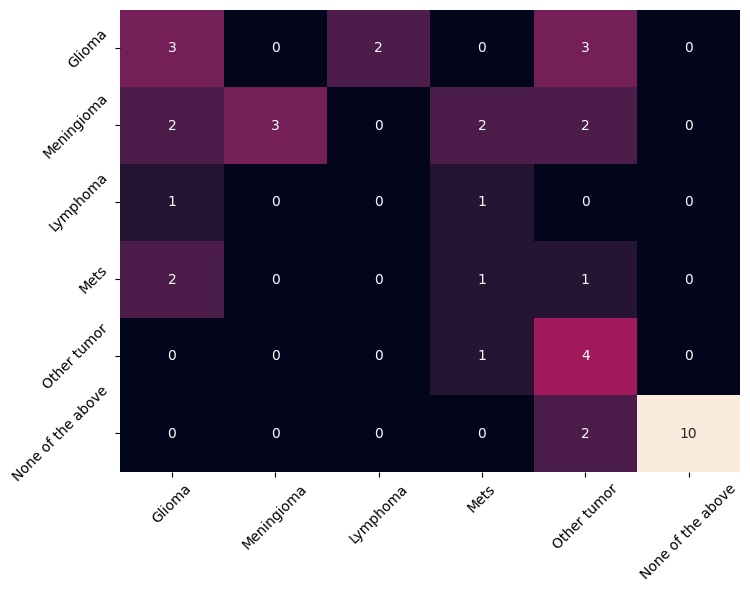

In [9]:
plot_confusion_matrix(soc_dx_a, soc_dx_b, dx_map)

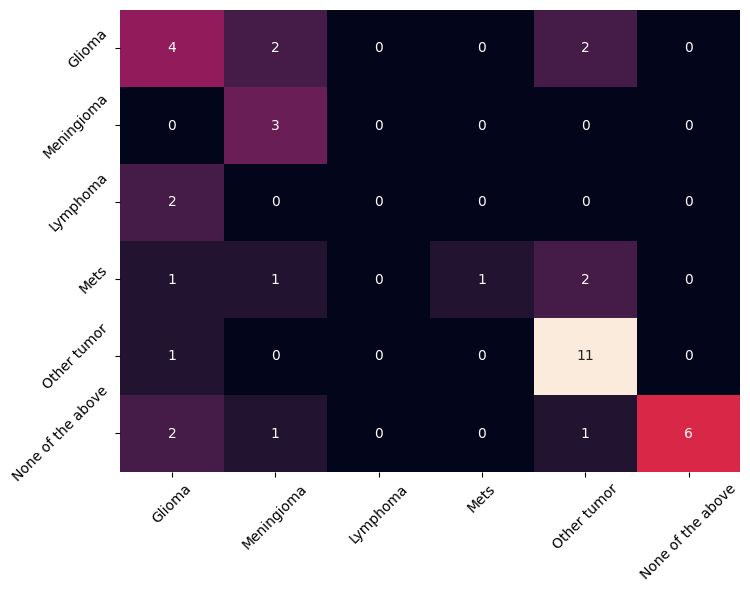

In [10]:
plot_confusion_matrix(soc_dx_b, soc_dx_c, dx_map)

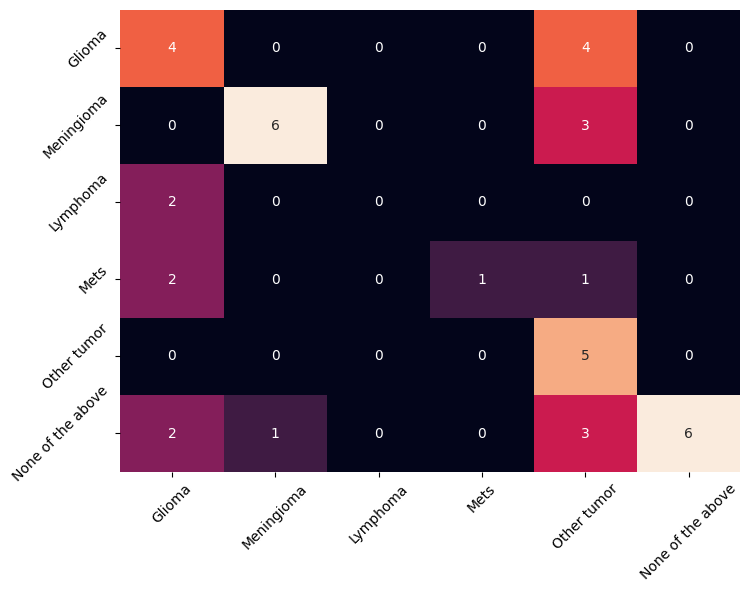

In [11]:
plot_confusion_matrix(soc_dx_a, soc_dx_c, dx_map)

### Inter-reader agreement of Dx on BOOST images

#### Percentage Agreement

In [12]:
bst_dx_a = list(df_scores.query(
    'reader == 0 and type == "boost" and repeat == "no"'
).sort_values('case')['dx'])

bst_dx_b = list(df_scores.query(
    'reader == 1 and type == "boost" and repeat == "no"'
).sort_values('case')['dx'])

bst_dx_c = list(df_scores.query(
    'reader == 2 and type == "boost" and repeat == "no"'
).sort_values('case')['dx'])

pct_dx_bst_ab, kap_dx_bst_ab = get_pct_and_kappa(bst_dx_a, bst_dx_b)
pct_dx_bst_bc, kap_dx_bst_bc = get_pct_and_kappa(bst_dx_b, bst_dx_c)
pct_dx_bst_ac, kap_dx_bst_ac = get_pct_and_kappa(bst_dx_a, bst_dx_c)

print('Percentage agreement - AB:{:.3f}, BC:{:.3f}, AC:{:.3f}'.format(pct_dx_bst_ab, pct_dx_bst_bc, pct_dx_bst_ac))
print('Cohens Kappa Score - AB:{:.3f}, BC:{:.3f}, AC:{:.3f}'.format(kap_dx_bst_ab, kap_dx_bst_bc, kap_dx_bst_ac))

Percentage agreement - AB:0.500, BC:0.525, AC:0.550
Cohens Kappa Score - AB:0.391, BC:0.406, AC:0.440


#### Intraclass Correlation Coefficient (ICC)

In [13]:
icc_dx_bst = pg.intraclass_corr(
    data=df_scores.query('type == "boost" and repeat == "no"'), targets='case', raters='reader', ratings='dx'
).round(3)
icc_dx_bst

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.469,3.648,39,80,0.0,"[0.28, 0.65]"
1,ICC2,Single random raters,0.475,3.911,39,78,0.0,"[0.29, 0.65]"
2,ICC3,Single fixed raters,0.492,3.911,39,78,0.0,"[0.3, 0.66]"
3,ICC1k,Average raters absolute,0.726,3.648,39,80,0.0,"[0.54, 0.85]"
4,ICC2k,Average random raters,0.731,3.911,39,78,0.0,"[0.55, 0.85]"
5,ICC3k,Average fixed raters,0.744,3.911,39,78,0.0,"[0.57, 0.86]"


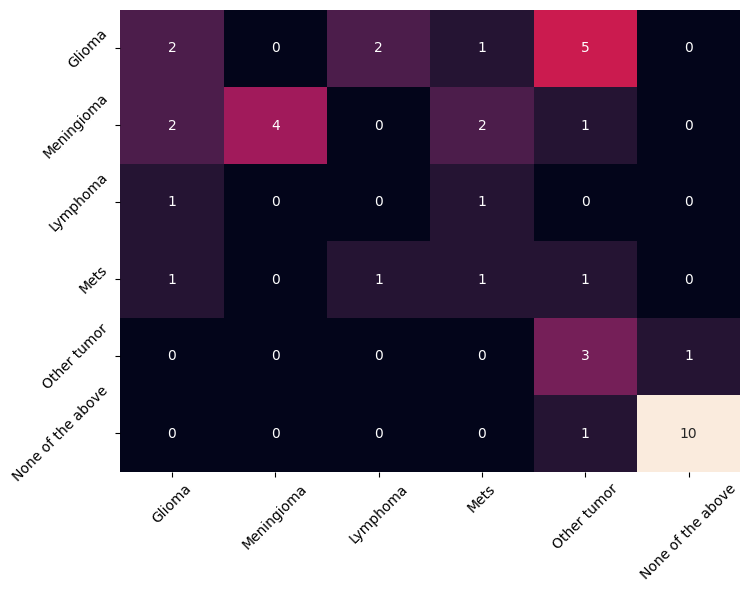

In [14]:
plot_confusion_matrix(bst_dx_a, bst_dx_b, dx_map)

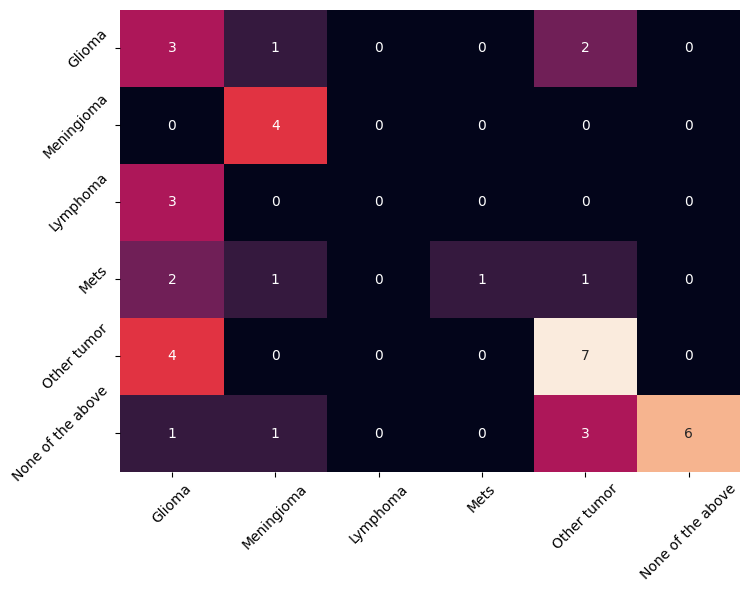

In [15]:
plot_confusion_matrix(bst_dx_b, bst_dx_c, dx_map)

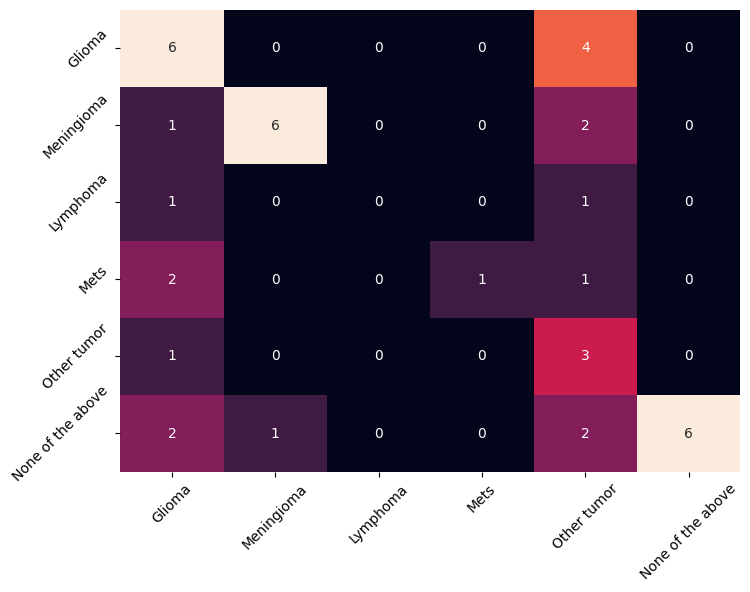

In [16]:
plot_confusion_matrix(bst_dx_a, bst_dx_c, dx_map)

### Inter-reader agreement of Dx on SOC vs BOOST images

#### Reader A <-> B

Cases where A reads SOC, B readers BOOST and A reads BOOST and B reads SOC

In [17]:
df_soc_a_bst_b = df_scores.query(
    '(reader == 0 and type == "soc" and repeat == "no") or (reader == 1 and type == "boost" and repeat == "no")'
)
dx_soc_a_bst_b = list(df_soc_a_bst_b.sort_values('case')['dx'])

df_bst_a_soc_b = df_scores.query(
    '(reader == 0 and type == "boost" and repeat == "no") or (reader == 1 and type == "soc" and repeat == "no")'
)
dx_bst_a_soc_b = list(df_bst_a_soc_b.sort_values('case')['dx'])

pct_ab, kap_ab = get_pct_and_kappa(dx_soc_a_bst_b, dx_bst_a_soc_b)

print('Inter reader agreement SOC vs BOOST AB <--> Percentage {:.3f}, Kappa {:.3f}'.format(pct_ab, kap_ab))

Inter reader agreement SOC vs BOOST AB <--> Percentage 0.512, Kappa 0.394


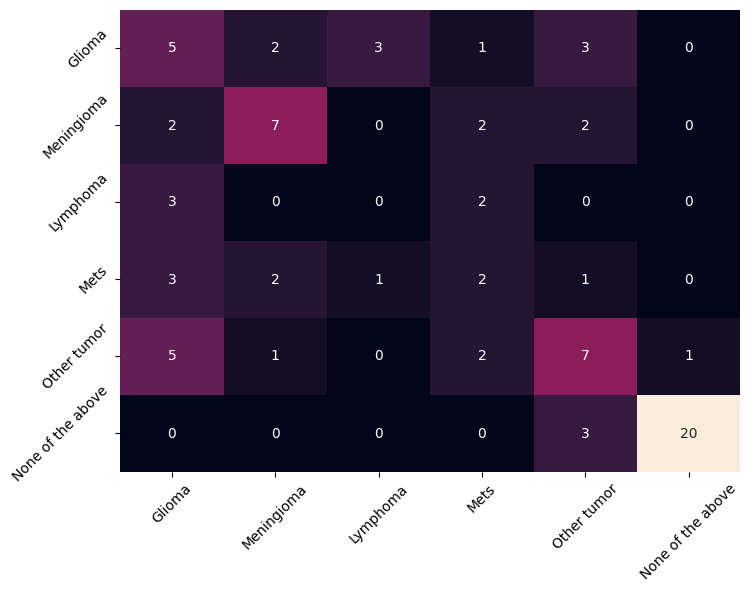

In [18]:
plot_confusion_matrix(dx_soc_a_bst_b, dx_bst_a_soc_b, dx_map)

In [19]:
df_inter_ab = df_soc_a_bst_b.append(df_bst_a_soc_b)
icc_inter_ab = pg.intraclass_corr(
    data=df_inter_ab, targets='case', raters='reader', ratings='dx'
).round(3)
icc_inter_ab

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.594,3.925,79,80,0.0,"[0.43, 0.72]"
1,ICC2,Single random raters,0.601,4.280,79,79,0.0,"[0.43, 0.73]"
2,ICC3,Single fixed raters,0.621,4.280,79,79,0.0,"[0.47, 0.74]"
3,ICC1k,Average raters absolute,0.745,3.925,79,80,0.0,"[0.6, 0.84]"
4,ICC2k,Average random raters,0.751,4.280,79,79,0.0,"[0.6, 0.84]"
5,ICC3k,Average fixed raters,0.766,4.280,79,79,0.0,"[0.64, 0.85]"


#### Reader B <-> C

In [20]:
df_soc_b_bst_c = df_scores.query(
    '(reader == 1 and type == "soc" and repeat == "no") or (reader == 2 and type == "boost" and repeat == "no")'
)
dx_soc_b_bst_c = list(df_soc_b_bst_c.sort_values('case')['dx'])

df_bst_b_soc_c = df_scores.query(
    '(reader == 1 and type == "boost" and repeat == "no") or (reader == 2 and type == "soc" and repeat == "no")'
)
dx_bst_b_soc_c = list(df_bst_b_soc_c.sort_values('case')['dx'])

pct_bc, kap_bc = get_pct_and_kappa(dx_soc_b_bst_c, dx_bst_b_soc_c)

print('Inter reader agreement SOC vs BOOST BC <--> Percentage {:.3f}, Kappa {:.3f}'.format(pct_bc, kap_bc))

Inter reader agreement SOC vs BOOST BC <--> Percentage 0.575, Kappa 0.452


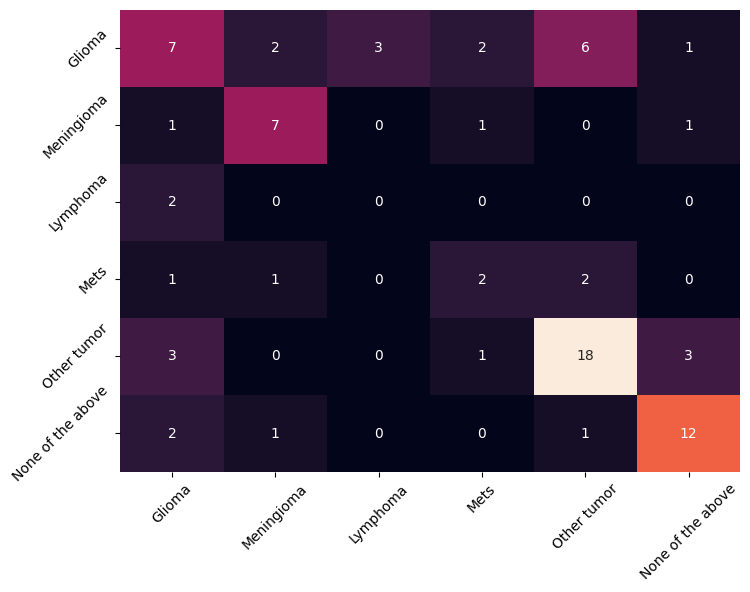

In [21]:
plot_confusion_matrix(dx_soc_b_bst_c, dx_bst_b_soc_c, dx_map)

In [22]:
df_inter_bc = df_soc_b_bst_c.append(df_bst_b_soc_c)
icc_inter_bc = pg.intraclass_corr(
    data=df_inter_bc, targets='case', raters='reader', ratings='dx'
).round(3)
icc_inter_bc

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.475,2.807,79,80,0.0,"[0.29, 0.63]"
1,ICC2,Single random raters,0.485,3.050,79,79,0.0,"[0.3, 0.64]"
2,ICC3,Single fixed raters,0.506,3.050,79,79,0.0,"[0.32, 0.65]"
3,ICC1k,Average raters absolute,0.644,2.807,79,80,0.0,"[0.45, 0.77]"
4,ICC2k,Average random raters,0.654,3.050,79,79,0.0,"[0.46, 0.78]"
5,ICC3k,Average fixed raters,0.672,3.050,79,79,0.0,"[0.49, 0.79]"


#### Reader A <-> C

In [23]:
df_soc_a_bst_c = df_scores.query(
    '(reader == 0 and type == "soc" and repeat == "no") or (reader == 2 and type == "boost" and repeat == "no")'
)
dx_soc_a_bst_c = list(df_soc_a_bst_c.sort_values('case')['dx'])

df_bst_a_soc_c = df_scores.query(
    '(reader == 0 and type == "boost" and repeat == "no") or (reader == 2 and type == "soc" and repeat == "no")'
)
dx_bst_a_soc_c = list(df_bst_a_soc_c.sort_values('case')['dx'])

pct_ac, kap_ac = get_pct_and_kappa(dx_soc_a_bst_c, dx_bst_a_soc_c)

print('Inter reader agreement SOC vs BOOST AC <--> Percentage {:.3f}, Kappa {:.3f}'.format(pct_ac, kap_ac))

Inter reader agreement SOC vs BOOST AC <--> Percentage 0.550, Kappa 0.427


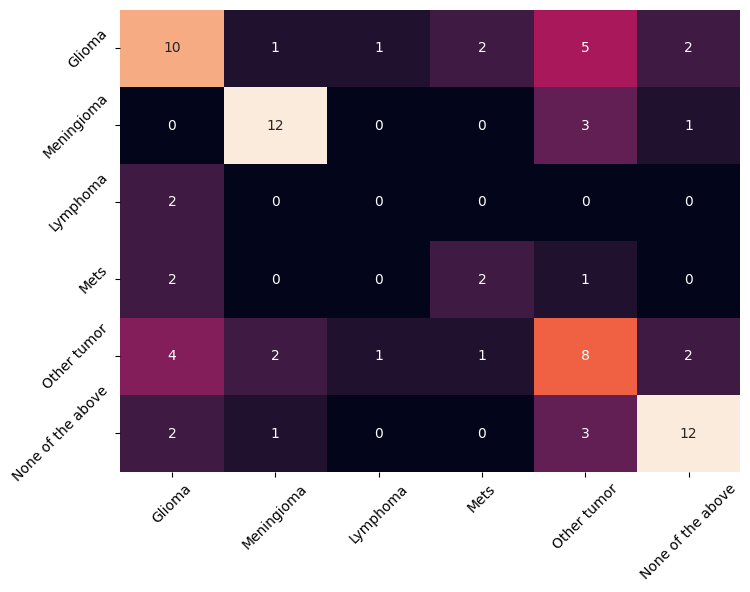

In [24]:
plot_confusion_matrix(dx_soc_a_bst_c, dx_bst_a_soc_c, dx_map)

In [25]:
df_inter_ac = df_soc_a_bst_c.append(df_bst_a_soc_c)
icc_inter_ac = pg.intraclass_corr(
    data=df_inter_ac, targets='case', raters='reader', ratings='dx'
).round(3)
icc_inter_ac

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.406,2.368,79,80,0.0,"[0.21, 0.57]"
1,ICC2,Single random raters,0.404,2.340,79,79,0.0,"[0.2, 0.57]"
2,ICC3,Single fixed raters,0.401,2.340,79,79,0.0,"[0.2, 0.57]"
3,ICC1k,Average raters absolute,0.578,2.368,79,80,0.0,"[0.34, 0.73]"
4,ICC2k,Average random raters,0.576,2.340,79,79,0.0,"[0.34, 0.73]"
5,ICC3k,Average fixed raters,0.573,2.340,79,79,0.0,"[0.33, 0.73]"


### Intra-reader agreement of SOC (repeat cases)

In [26]:
df_soc_intra_a_rep = df_scores.query('reader == 0 and type == "soc" and repeat == "yes"')
dx_soc_intra_a_rep = list(df_soc_intra_a_rep.sort_values('original')['dx'])
orig_soc_reps = list(df_soc_intra_a_rep['original'])

dx_soc_intra_a_orig = list(
    df_scores.query(
        'reader == 0 and type == "soc" and repeat == "no" and original in @orig_soc_reps'
    ).sort_values('original')['dx']
)

pct_soc_intra_a, kap_soc_intra_a = get_pct_and_kappa(dx_soc_intra_a_orig, dx_soc_intra_a_rep)
print('Intra reader agreement SOC: A <--> Percentage {:.3f}, Kappa {:.3f}'.format(pct_soc_intra_a, kap_soc_intra_a))

Intra reader agreement SOC: A <--> Percentage 0.900, Kappa 0.873


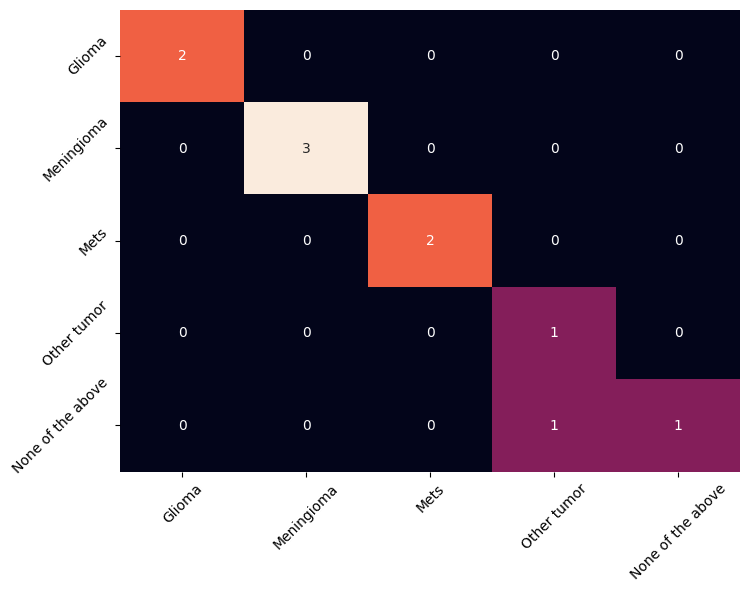

In [27]:
plot_confusion_matrix(dx_soc_intra_a_orig, dx_soc_intra_a_rep, dx_map)

In [28]:
df_soc_intra_b_rep = df_scores.query('reader == 1 and type == "soc" and repeat == "yes"')
dx_soc_intra_b_rep = list(df_soc_intra_b_rep.sort_values('original')['dx'])

dx_soc_intra_b_orig = list(
    df_scores.query(
        'reader == 1 and type == "soc" and repeat == "no" and original in @orig_soc_reps'
    ).sort_values('original')['dx']
)

pct_soc_intra_b, kap_soc_intra_b = get_pct_and_kappa(dx_soc_intra_b_orig, dx_soc_intra_b_rep)
print('Intra reader agreement SOC: B <--> Percentage {:.3f}, Kappa {:.3f}'.format(pct_soc_intra_b, kap_soc_intra_b))

Intra reader agreement SOC: B <--> Percentage 0.700, Kappa 0.610


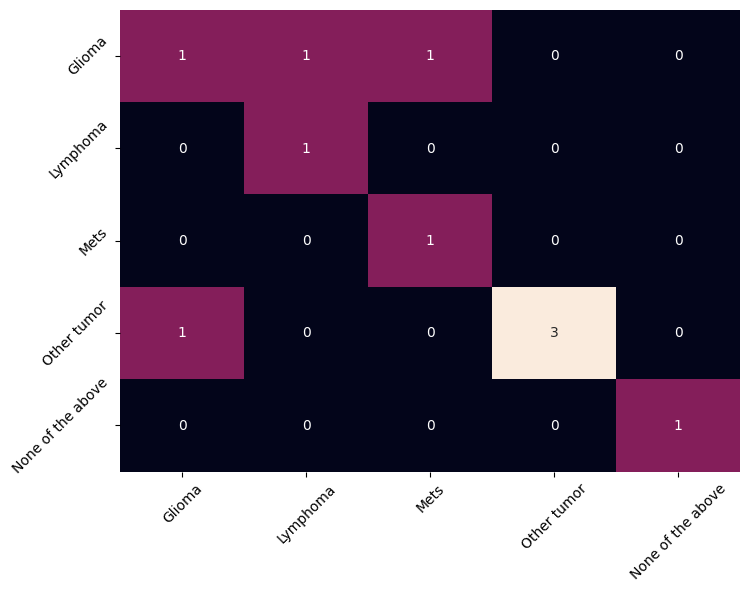

In [29]:
plot_confusion_matrix(dx_soc_intra_b_orig, dx_soc_intra_b_rep, dx_map)

In [30]:
df_soc_intra_c_rep = df_scores.query('reader == 2 and type == "soc" and repeat == "yes"')
dx_soc_intra_c_rep = list(df_soc_intra_c_rep.sort_values('original')['dx'])

dx_soc_intra_c_orig = list(
    df_scores.query(
        'reader == 2 and type == "soc" and repeat == "no" and original in @orig_soc_reps'
    ).sort_values('original')['dx']
)

pct_soc_intra_c, kap_soc_intra_c = get_pct_and_kappa(dx_soc_intra_c_orig, dx_soc_intra_c_rep)
print('Intra reader agreement SOC: C <--> Percentage {:.3f}, Kappa {:.3f}'.format(pct_soc_intra_c, kap_soc_intra_c))

Intra reader agreement SOC: C <--> Percentage 1.000, Kappa 1.000


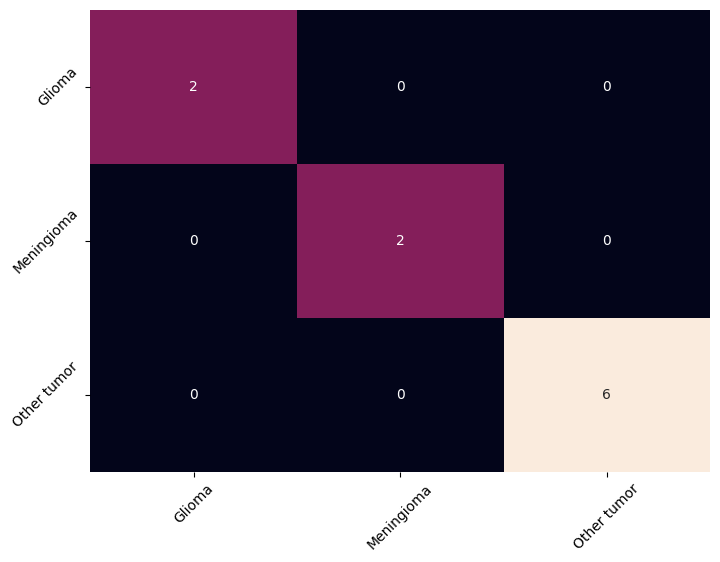

In [31]:
plot_confusion_matrix(dx_soc_intra_c_orig, dx_soc_intra_c_rep, dx_map)

### Intra-reader agreement of BOOST (repeat cases)

In [32]:
df_bst_intra_a_rep = df_scores.query('reader == 0 and type == "boost" and repeat == "yes"')
dx_bst_intra_a_rep = list(df_bst_intra_a_rep.sort_values('original')['dx'])
orig_bst_reps = list(df_bst_intra_a_rep['original'])

dx_bst_intra_a_orig = list(
    df_scores.query(
        'reader == 0 and type == "boost" and repeat == "no" and original in @orig_bst_reps'
    ).sort_values('original')['dx']
)

pct_bst_intra_a, kap_bst_intra_a = get_pct_and_kappa(dx_bst_intra_a_orig, dx_bst_intra_a_rep)
print('Intra reader agreement BOOST: A <--> Percentage {:.3f}, Kappa {:.3f}'.format(pct_bst_intra_a, kap_bst_intra_a))

Intra reader agreement BOOST: A <--> Percentage 0.900, Kappa 0.867


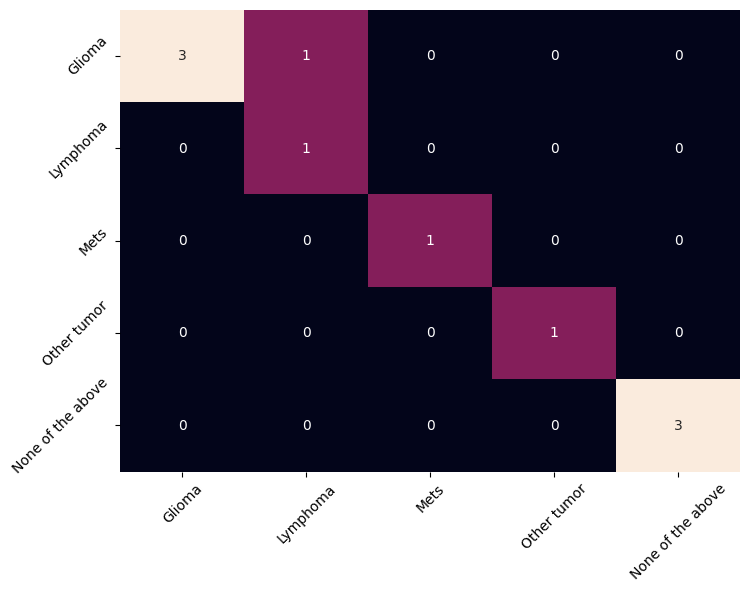

In [33]:
plot_confusion_matrix(dx_bst_intra_a_orig, dx_bst_intra_a_rep, dx_map)

In [34]:
df_bst_intra_b_rep = df_scores.query('reader == 1 and type == "boost" and repeat == "yes"')
dx_bst_intra_b_rep = list(df_bst_intra_b_rep.sort_values('original')['dx'])

dx_bst_intra_b_orig = list(
    df_scores.query(
        'reader == 1 and type == "boost" and repeat == "no" and original in @orig_bst_reps'
    ).sort_values('original')['dx']
)

pct_bst_intra_b, kap_bst_intra_b = get_pct_and_kappa(dx_bst_intra_b_orig, dx_bst_intra_b_rep)
print('Intra reader agreement BOOST: B <--> Percentage {:.3f}, Kappa {:.3f}'.format(pct_bst_intra_b, kap_bst_intra_b))

Intra reader agreement BOOST: B <--> Percentage 0.900, Kappa 0.857


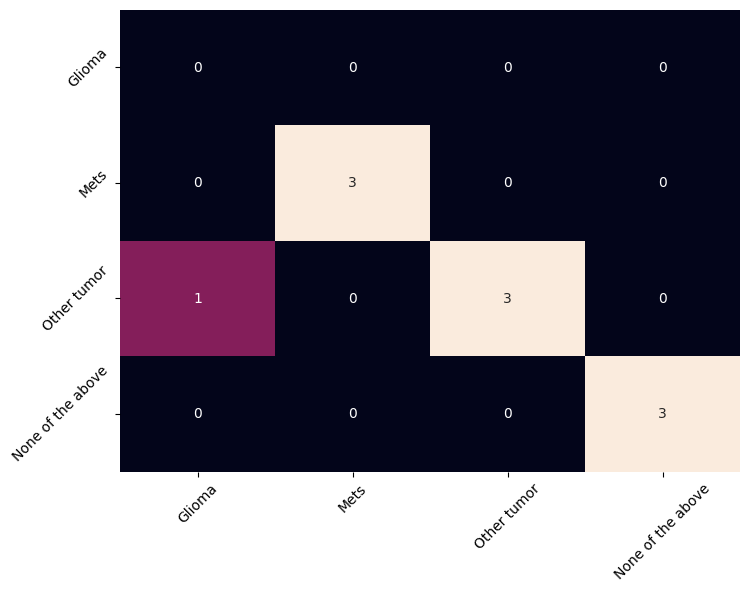

In [35]:
plot_confusion_matrix(dx_bst_intra_b_orig, dx_bst_intra_b_rep, dx_map)

In [36]:
df_bst_intra_c_rep = df_scores.query('reader == 2 and type == "boost" and repeat == "yes"')
dx_bst_intra_c_rep = list(df_bst_intra_c_rep.sort_values('original')['dx'])

dx_bst_intra_c_orig = list(
    df_scores.query(
        'reader == 2 and type == "boost" and repeat == "no" and original in @orig_bst_reps'
    ).sort_values('original')['dx']
)

pct_bst_intra_c, kap_bst_intra_c = get_pct_and_kappa(dx_bst_intra_c_orig, dx_bst_intra_c_rep)
print('Intra reader agreement BOOST: B <--> Percentage {:.3f}, Kappa {:.3f}'.format(pct_bst_intra_c, kap_bst_intra_c))

Intra reader agreement BOOST: B <--> Percentage 1.000, Kappa 1.000


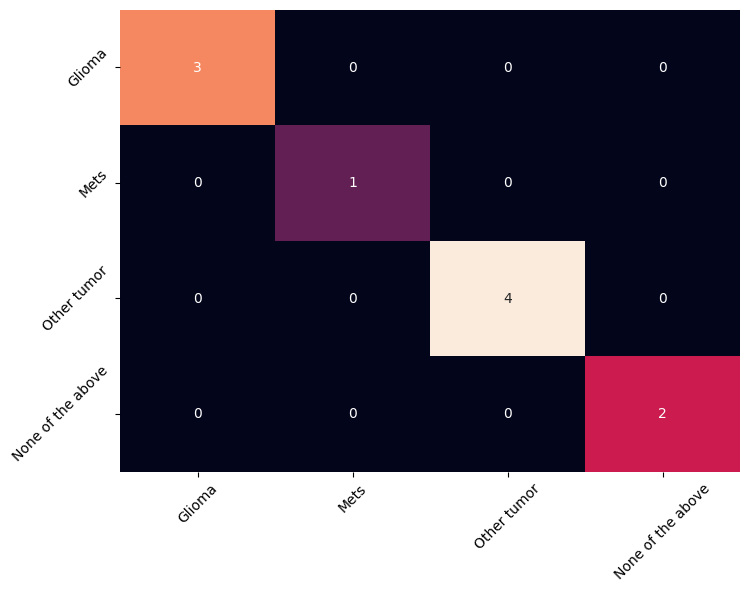

In [37]:
plot_confusion_matrix(dx_bst_intra_c_orig, dx_bst_intra_c_rep, dx_map)

### Intra-reader agreement of SOC vs BOOST

In [38]:
dx_intra_soc_a = list(df_scores.query(
    'reader == 0 and repeat == "no" and type == "soc"'
).sort_values('original')['dx'])

dx_intra_bst_a = list(df_scores.query(
    'reader == 0 and repeat == "no" and type == "boost"'
).sort_values('original')['dx'])

pct_intra_a, kap_intra_a = get_pct_and_kappa(dx_intra_soc_a, dx_intra_bst_a)
print(
    'Intra reader agreement SOC vs BOOST: A <--> Percentage {:.3f}, Kappa {:.3f}'.format(
        pct_intra_a, kap_intra_a
    )
)

Intra reader agreement SOC vs BOOST: A <--> Percentage 0.925, Kappa 0.905


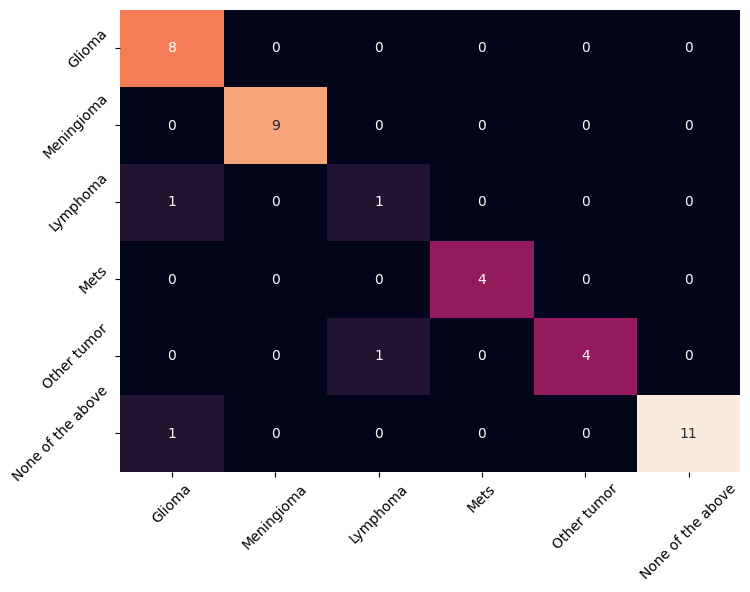

In [39]:
plot_confusion_matrix(dx_intra_soc_a, dx_intra_bst_a, dx_map)

In [40]:
dx_intra_soc_b = list(df_scores.query(
    'reader == 1 and repeat == "no" and type == "soc"'
).sort_values('original')['dx'])

dx_intra_bst_b = list(df_scores.query(
    'reader == 1 and repeat == "no" and type == "boost"'
).sort_values('original')['dx'])

pct_intra_b, kap_intra_b = get_pct_and_kappa(dx_intra_soc_b, dx_intra_bst_b)
print(
    'Intra reader agreement SOC vs BOOST: B <--> Percentage {:.3f}, Kappa {:.3f}'.format(
        pct_intra_b, kap_intra_b
    )
)

Intra reader agreement SOC vs BOOST: B <--> Percentage 0.750, Kappa 0.684


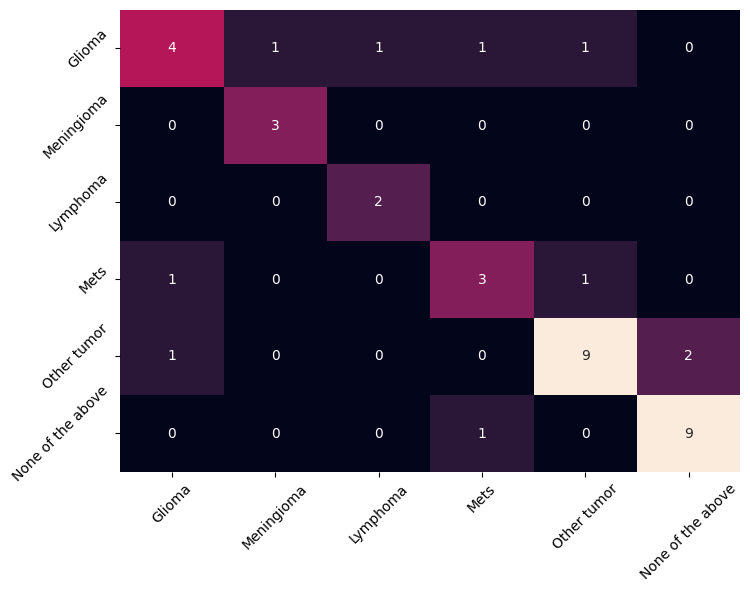

In [41]:
plot_confusion_matrix(dx_intra_soc_b, dx_intra_bst_b, dx_map)

In [42]:
dx_intra_soc_c = list(df_scores.query(
    'reader == 2 and repeat == "no" and type == "soc"'
).sort_values('original')['dx'])

dx_intra_bst_c = list(df_scores.query(
    'reader == 2 and repeat == "no" and type == "boost"'
).sort_values('original')['dx'])

pct_intra_c, kap_intra_c = get_pct_and_kappa(dx_intra_soc_c, dx_intra_bst_c)
print(
    'Intra reader agreement SOC vs BOOST: C <--> Percentage {:.3f}, Kappa {:.3f}'.format(
        pct_intra_c, kap_intra_c
    )
)

Intra reader agreement SOC vs BOOST: C <--> Percentage 0.875, Kappa 0.830


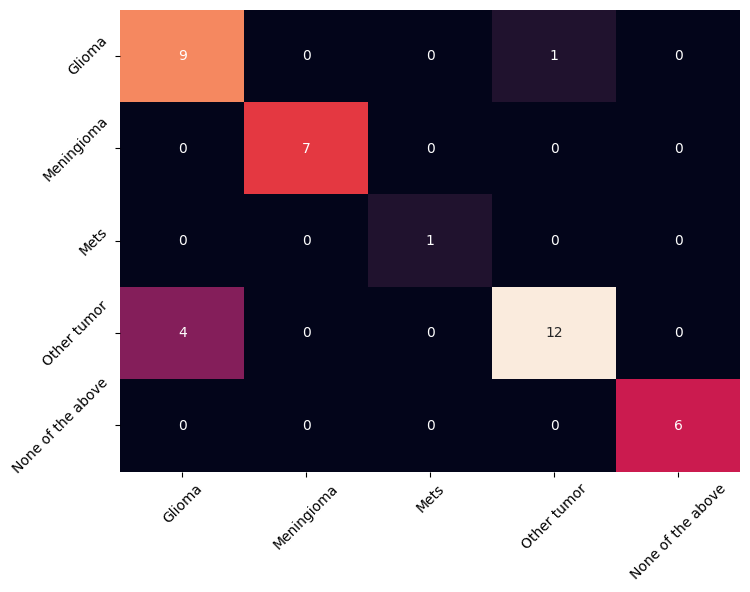

In [133]:
plot_confusion_matrix(dx_intra_soc_c, dx_intra_bst_c, dx_map)

### Analysis of Contrast enhancement

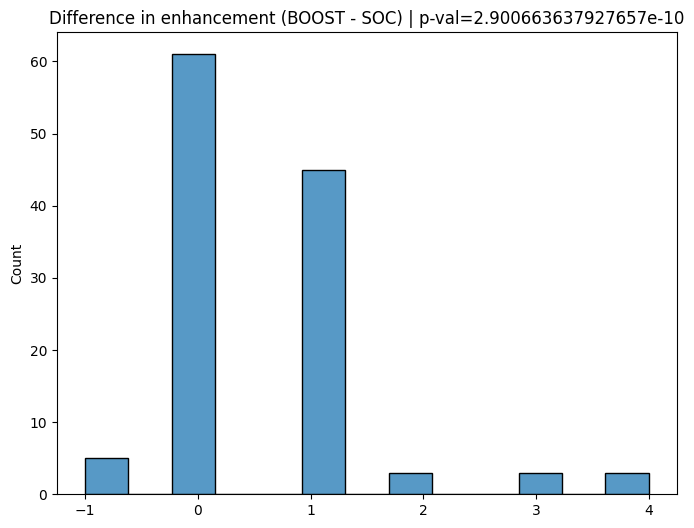

In [44]:
plot_hist_with_pval(df_scores, col='enhancement')

### Analysis of Border Delineation

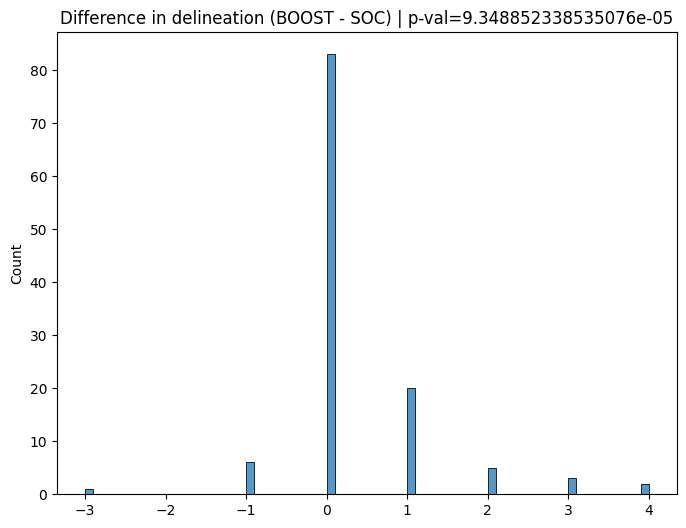

In [45]:
plot_hist_with_pval(df_scores, col='delineation')

### Analysis of Internal Morphology

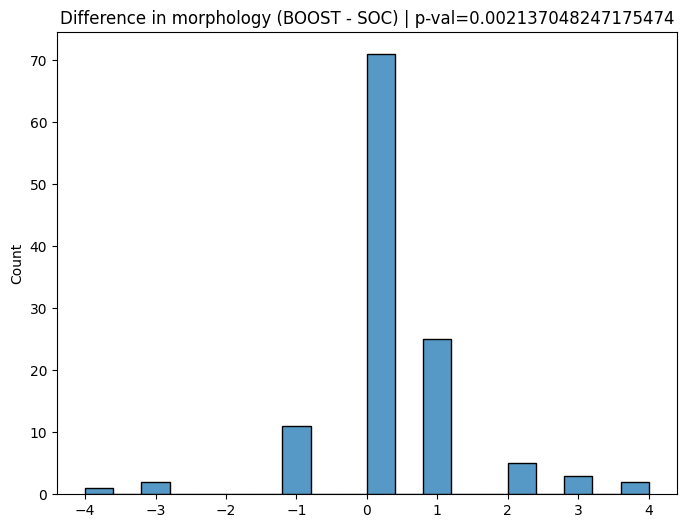

In [46]:
plot_hist_with_pval(df_scores, col='morphology')

### Analysis of Overall Image Quality (IQ)

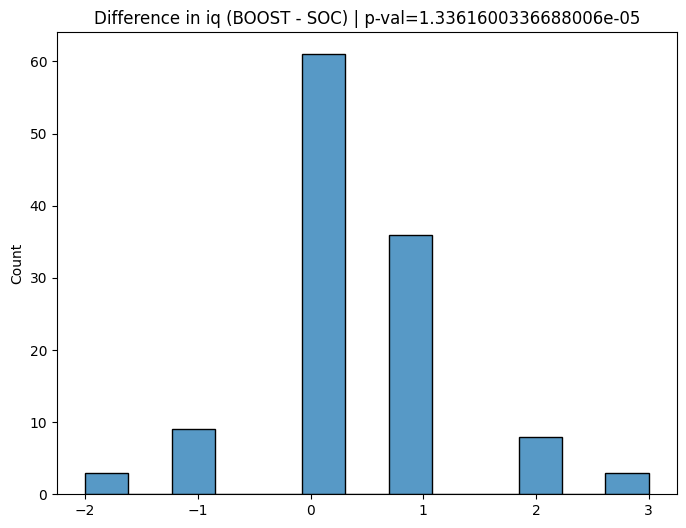

In [47]:
plot_hist_with_pval(df_scores, col='iq')

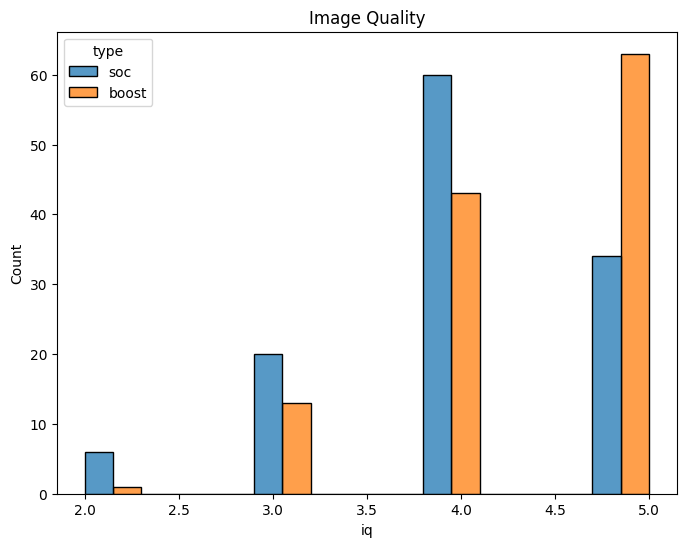

In [48]:
iq_hist = sns.histplot(
    data=df_scores.query('repeat == "no"'), x='iq', hue='type', multiple='dodge'
)
_ = iq_hist.set(title='Image Quality')

### Analysis of Vessel Conspicuity

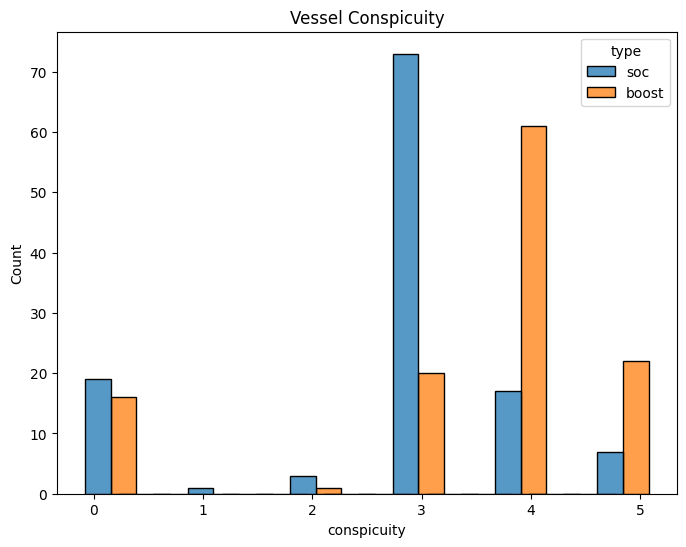

In [6]:
consp_hist = sns.histplot(
    data=df_scores.query('repeat == "no"'), x='conspicuity', hue='type', multiple='dodge', shrink=1.5
)
_ = consp_hist.set(title='Vessel Conspicuity')

### Effect of case type (SOC/BOOST) on vessel conspicuity affecting the Dx

In [7]:
df_filt = df_scores.query('repeat == "no"').sort_values(['case', 'reader'])
types = [1 if t == 'soc' else 2 for t in list(df_filt['type'])]
affect_dx = [1 if c == 'yes' else 0 for c in list(df_filt['conspicuity_affects_dx'])]

rho, rho_pval = pearsonr(types, affect_dx)

print(
'Pearson correlation analysis of case type\
(soc/boost) influencing the "conspicuity_affects_dx" variable: rho={:.3f}; p-val={:.3f}'.format(rho, rho_pval)
)

Pearson correlation analysis of case type(soc/boost) influencing the "conspicuity_affects_dx" variable: rho=0.176; p-val=0.006


Text(0.5, 1.0, 'Whether conspicuity affects Dx (Boost only)')

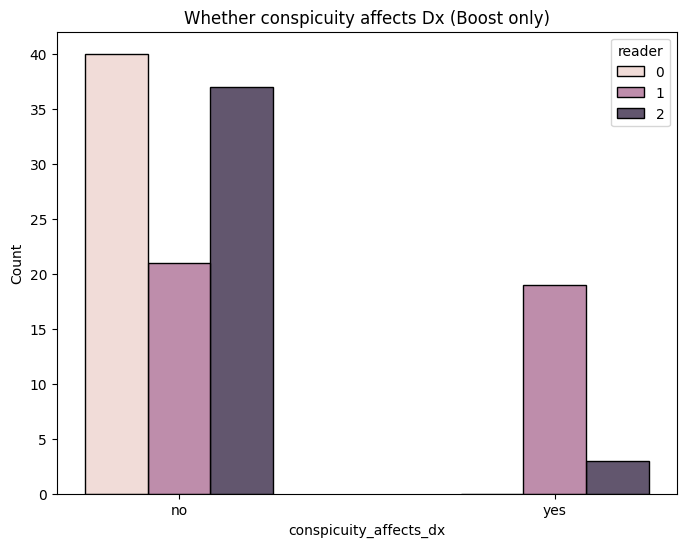

In [10]:
sns.histplot(
    df_filt.query('type == "boost"'), x='conspicuity_affects_dx', hue='reader', multiple='dodge', shrink=0.5
)
plt.title('Whether conspicuity affects Dx (Boost only)')

### Diagnostic Interchangeability

```
agreement ~ comparison + (1|case) + (1|reader)
```

- `agreement` - 1 if the two readers agree on the Dx,  0 if not
- `comparison` - 0 if two readers are reading SOC, 1 if A is reading SOC and B is reading BOOST or vice-versa
- `case` - unique ID assigned based on the `original` column in `df_scores`
- `reader` reader combination ID (0 - AB, 1 - BC, 2 - AC)

In [52]:
ixg_rows_ab = get_agreement_rows(df_scores, reader1=0, reader2=1, comb_id=0)
ixg_rows_bc = get_agreement_rows(df_scores, reader1=1, reader2=2, comb_id=1)
ixg_rows_ac = get_agreement_rows(df_scores, reader1=0, reader2=2, comb_id=2)

df_agreement = pd.DataFrame(ixg_rows_ab + ixg_rows_bc + ixg_rows_ac)
df_agreement.to_csv(f'{base_path}/agreement_glm.csv')

In [56]:
df_agreement

,case,comparison,reader,agreement
0,0,0,0,1
1,1,0,0,0
2,2,0,0,1
3,3,0,0,0
4,4,0,0,0
...,...,...,...,...
355,35,1,2,1
356,36,1,2,0
357,37,1,2,1
358,38,1,2,1


**Output from `glmer`** (`/home/srivathsa/projects/studies/gad/boost/glmer_analysis.r`)

```
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: agreement ~ comparison + (1 | case) + (1 | reader)
   Data: data

     AIC      BIC   logLik deviance df.resid
   400.9    416.4   -196.4    392.9      356

Scaled residuals:
    Min      1Q  Median      3Q     Max
-1.8060 -0.7090  0.2214  0.2483  2.3352

Random effects:
 Groups Name        Variance Std.Dev.
 case   (Intercept) 4.84186  2.2004
 reader (Intercept) 0.01457  0.1207
Number of obs: 360, groups:  case, 40; reader, 3

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   0.7403     0.4397   1.684   0.0923 .
comparison   -0.1716     0.2830  -0.606   0.5442
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
           (Intr)
comparison -0.435
```

### Effect of IQ on Dx intra-reader agreement (BOOST vs SOC)

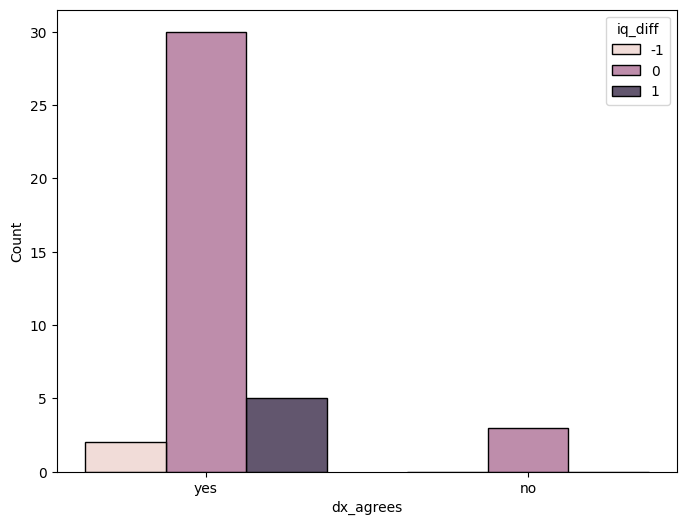

In [53]:
plot_iq_effect_on_dx(df_scores, 0)

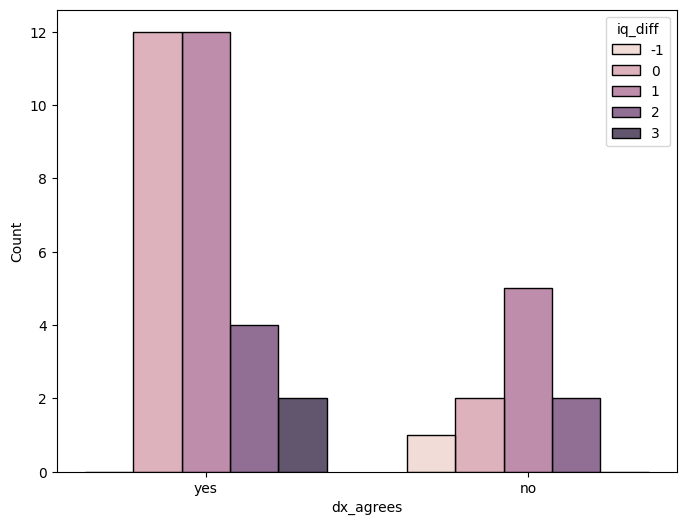

In [54]:
plot_iq_effect_on_dx(df_scores, 1)

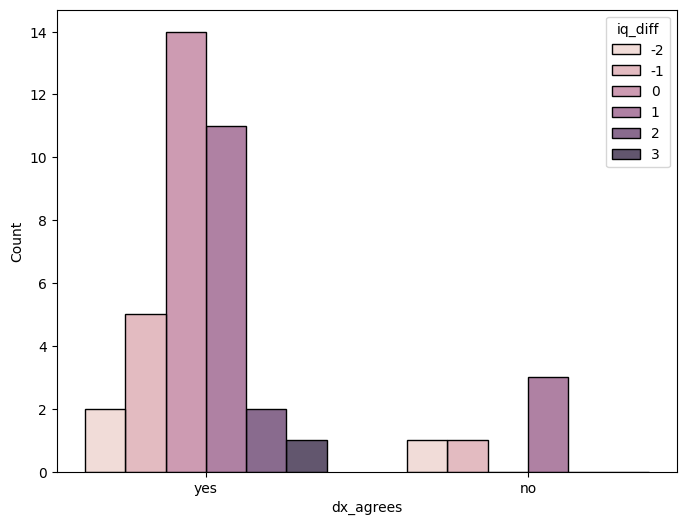

In [55]:
plot_iq_effect_on_dx(df_scores, 2)

### Analysis with Dx ground truth

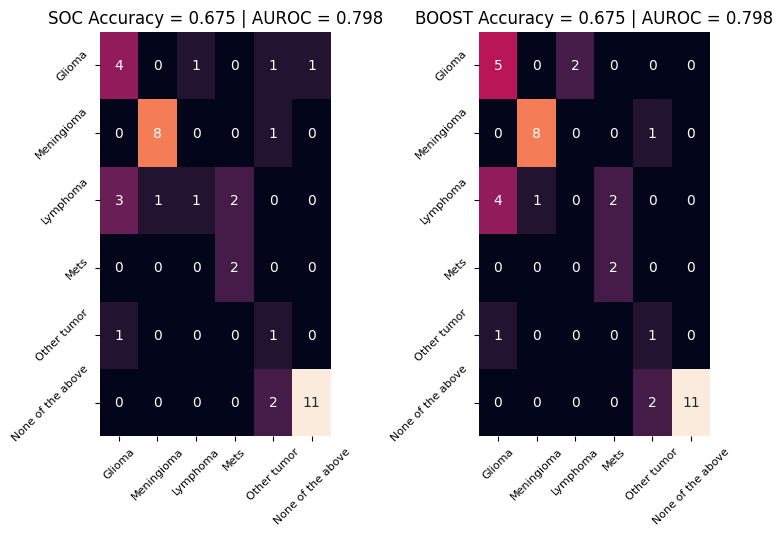

In [134]:
comparison_with_dx_gt(df_scores, 0, dx_map)

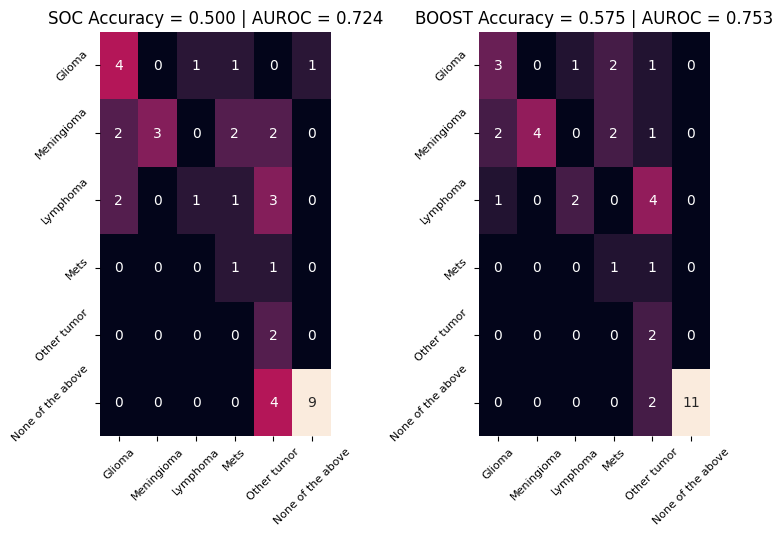

In [135]:
comparison_with_dx_gt(df_scores, 1, dx_map)

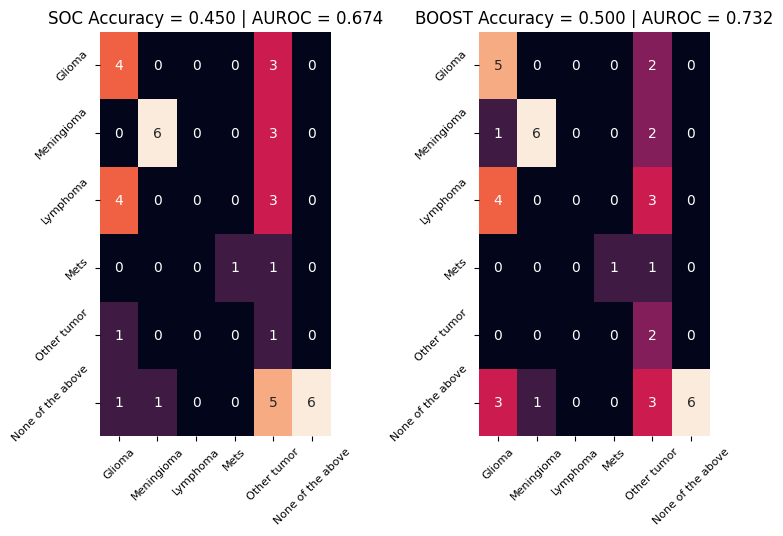

In [136]:
comparison_with_dx_gt(df_scores, 2, dx_map)